In [144]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import catboost as cb
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
import warnings

In [145]:
#Define random seed for result reproduction
random_seed = 30
np.random.seed(random_seed)

In [146]:
# Load the pickle file
pickle_path = "/Users/lantyynka/PycharmProjects/datax-project/sandbox/veronika_junkova/final_data.pck"

with open(pickle_path, 'rb') as f:
    data = pickle.load(f)
    
warnings.filterwarnings('ignore')

In [147]:
# separate features and target variable
X = df.drop(target, axis=1)
y = df[target]

# remove columns with any missing values
X = X.dropna(axis=1, how='any')

# one hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

Linear regression

In [148]:
# Modeling
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_lr = r2_score(y_test, y_pred)

print("Linear regression results")
print(f"RMSE: {rmse_lr}")
print(f"R^2: {r2_lr}")

Linear regression results
RMSE: 1141.3471069808813
R^2: 0.44536936300829255


Random forest

In [149]:
# Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=random_seed)
rf.fit(X_train, y_train)

# predictions for the test set
y_pred_rf = rf.predict(X_test)

# calculating r2 for random forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest results")
print(f"RMSE: {rmse_rf}")
print(f"R^2: {r2_rf}")

Random Forest results
RMSE: 974.1118304543648
R^2: 0.5959956821800911


Optimalized random forest

In [150]:
# RandomForestRegressor
orf_regressor = RandomForestRegressor(random_state=random_seed, n_jobs=-1)


param_grid_orf = {
    'n_estimators': [200, 300, 500],
    'max_features': [4,6],
    'min_samples_split': [3,10],
    'bootstrap': [True, False]
}

# GridSearchCV
grid_search_orf = GridSearchCV(estimator=orf_regressor, param_grid=param_grid_orf, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Training model
grid_search_orf.fit(X_train, y_train)

# Best parametres
best_params_orf = grid_search_orf.best_params_
print(f"Best params: {best_params_orf}")

# Best model
best_model_orf = grid_search_orf.best_estimator_

# Prediction with best model
predictions_orf = best_model_orf.predict(X_test)

# Model evaluation
rmse_orf = np.sqrt(mean_squared_error(y_test, predictions_orf))
r2_orf = r2_score(y_test, predictions_orf)

print("Optimized Random Forest results")
print(f"RMSE: {rmse_orf}")
print(f"R^2: {r2_orf}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'bootstrap': False, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 500}
Optimized Random Forest results
RMSE: 932.6213152153763
R^2: 0.6296783990916408


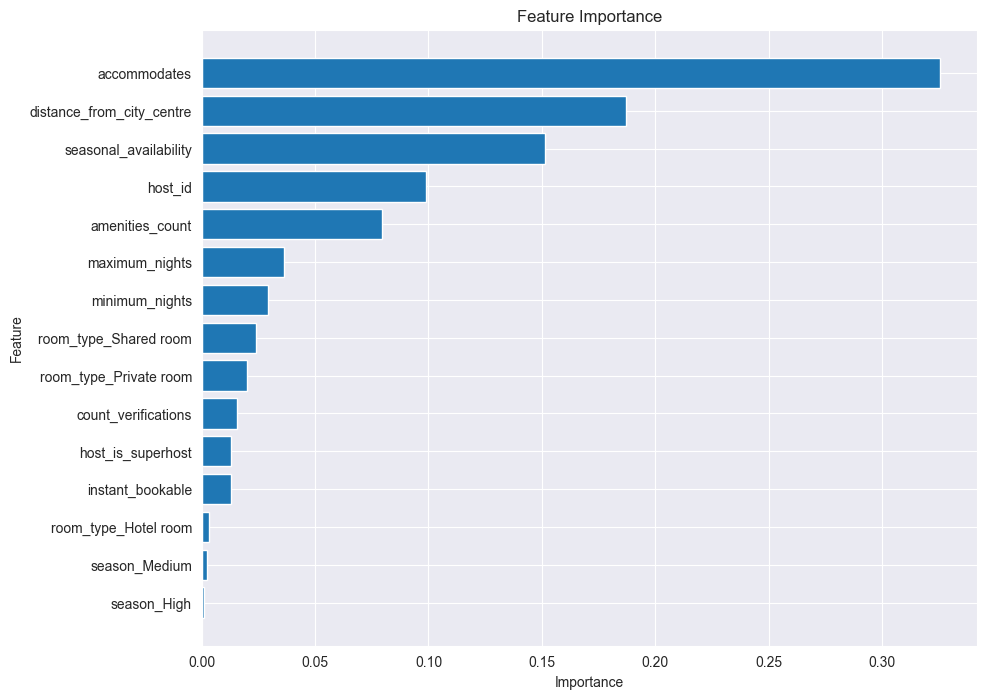

,Feature,Importance
2,accommodates,0.325421
9,distance_from_city_centre,0.187043
8,seasonal_availability,0.151170
0,host_id,0.098812
6,amenities_count,0.079551
4,maximum_nights,0.036422
3,minimum_nights,0.029428
12,room_type_Shared room,0.023867
10,room_type_Private room,0.019775
7,count_verifications,0.015686


In [151]:
# Feature importance
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

feature_importances.head(10)

XGBoost

In [152]:
xgb1_regressor = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, random_state=random_seed)
xgb1_regressor.fit(X_train, y_train)
y_pred_xgb1 = xgb1_regressor.predict(X_test)

rmse_xgb1 = np.sqrt(mean_squared_error(y_test, y_pred_xgb1))
r2_xgb1 = r2_score(y_test, y_pred_xgb1)

print("XGBoost results")
print(f"RMSE: {rmse_xgb1}")
print("R2: {:.2f}".format(r2_xgb1))

XGBoost results
RMSE: 960.7316810652815
R2: 0.61


Optimized XGBoost

In [153]:
# Custom XGBoost wrapper to include early stopping
class XGBRegressorEarlyStopping(xgb.XGBRegressor):
    def __init__(self, early_stopping_rounds=10, **kwargs):
        super().__init__(**kwargs)
        self.early_stopping_rounds = early_stopping_rounds

    def fit(self, X, y, eval_set=None, **kwargs):
        if eval_set is None:
            eval_set = [(X, y)]
        return super().fit(X, y, eval_set=eval_set, **kwargs)

# Pipeline with scaling and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressorEarlyStopping(objective='reg:squarederror', random_state=random_seed, early_stopping_rounds=10))
])

# Parameter distribution for randomized search
param_dist = {
    'xgb__n_estimators': randint(50, 200),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__max_depth': randint(3, 10),
    'xgb__min_child_weight': randint(1, 6),
    'xgb__subsample': uniform(0.5, 0.5),
    'xgb__colsample_bytree': uniform(0.5, 0.5),
    'xgb__gamma': uniform(0, 0.4),
    'xgb__reg_alpha': uniform(0, 1),
    'xgb__reg_lambda': uniform(0.5, 2)
}

# Randomized search
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=50, 
                                   cv=3, n_jobs=-1, verbose=2, scoring='r2', random_state=random_seed)
random_search.fit(X_train, y_train)

# Best model
best_pipeline = random_search.best_estimator_

# Predictions and evaluation
y_pred_xgb = best_pipeline.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("Best R2: {:.2f}".format(r2_xgb))
print("Best RMSE: {:.2f}".format(rmse_xgb))
print("Best Parameters: ", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[0]	validation_0-rmse:1329.09155
[1]	validation_0-rmse:1238.24146
[2]	validation_0-rmse:1163.65685
[3]	validation_0-rmse:1107.73375
[0]	validation_0-rmse:1475.49123
[4]	validation_0-rmse:1071.97677
[1]	validation_0-rmse:1456.65604
[5]	validation_0-rmse:1035.03642
[6]	validation_0-rmse:1009.59973
[7]	validation_0-rmse:990.85501
[2]	validation_0-rmse:1428.27911
[8]	validation_0-rmse:971.22224
[3]	validation_0-rmse:1405.16533
[9]	validation_0-rmse:956.66437
[4]	validation_0-rmse:1388.94445
[10]	validation_0-rmse:942.30816
[11]	validation_0-rmse:930.75968
[5]	validation_0-rmse:1349.30710
[12]	validation_0-rmse:920.15099
[6]	validation_0-rmse:1338.09082
[13]	validation_0-rmse:913.48046
[7]	validation_0-rmse:1325.48985
[14]	validation_0-rmse:907.73387
[15]	validation_0-rmse:901.32521
[8]	validation_0-rmse:1295.61724
[9]	validation_0-rmse:1266.96745
[16]	validation_0-rmse:896.65368
[17]	validation_0-rmse:891.17918
[10]	validation_0

Catboost

In [154]:
# CatBoostRegressor
cb_regressor = cb.CatBoostRegressor(random_seed=random_seed, silent=True)

# RandomizedSearch parameters
param_distributions_cb = {
    'iterations': [500, 1000, 1500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0]
}

# RandomizedSearchCV
random_search_cb = RandomizedSearchCV(
    estimator=cb_regressor,
    param_distributions=param_distributions_cb,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=random_seed
)

random_search_cb.fit(X_train, y_train)

# Best params
best_params_cb = random_search_cb.best_params_
print(f"Best params: {best_params_cb}")

# Best model
best_model_cb = random_search_cb.best_estimator_

# Prediction
predictions_cb = best_model_cb.predict(X_test)

# Model evaluation
rmse_cb = np.sqrt(mean_squared_error(y_test, predictions_cb))
r2_cb = r2_score(y_test, predictions_cb)

print("CatBoost results")
print(f"RMSE: {rmse_cb}")
print(f"R^2: {r2_cb}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best params: {'subsample': 0.9, 'learning_rate': 0.1, 'l2_leaf_reg': 9, 'iterations': 1000, 'depth': 8, 'colsample_bylevel': 0.9, 'bootstrap_type': 'Bernoulli'}
CatBoost results
RMSE: 905.2208935365344
R^2: 0.6511188462653443


In [158]:
# Model comparison
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', "Optimized Random Forest", 'CatBoost', 'XGBoost', "Optimized XGBoost"],
    'RMSE': [rmse_lr, rmse_rf, rmse_orf, rmse_cb, rmse_xgb1 , rmse_xgb],
    'R²': [r2_lr, r2_rf, r2_orf , r2_cb, r2_xgb1 , r2_xgb]
})

print(results)

                     Model         RMSE        R²
0        Linear Regression  1141.347107  0.445369
1            Random Forest   974.111830  0.595996
2  Optimized Random Forest   932.621315  0.629678
3                 CatBoost   905.220894  0.651119
4                  XGBoost   960.731681  0.607018
5        Optimized XGBoost   917.517553  0.641576


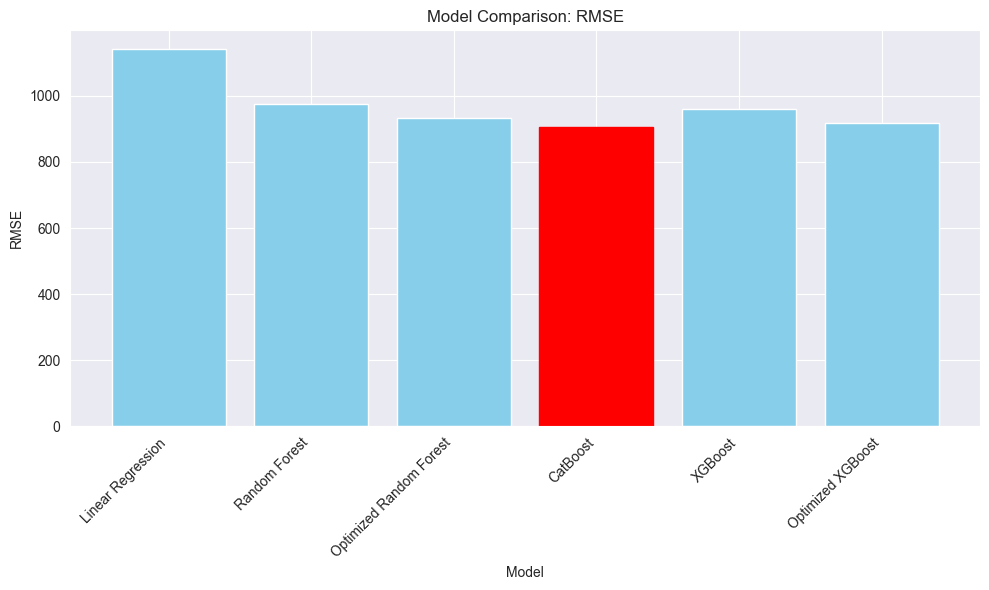

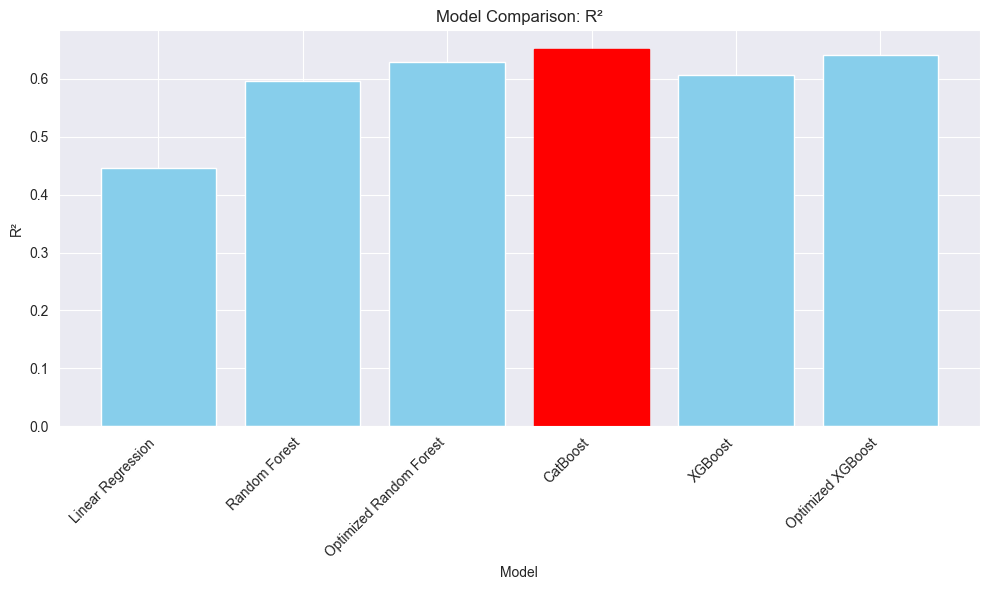

In [161]:
# Determine the best RMSE and R²
best_rmse_index = results['RMSE'].idxmin()
best_r2_index = results['R²'].idxmax()

# RMSE
plt.figure(figsize=(10, 6))
bars = plt.bar(results['Model'], results['RMSE'], color='skyblue')
bars[best_rmse_index].set_color('red')
plt.title('Model Comparison: RMSE')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# R²
plt.figure(figsize=(10, 6))
bars = plt.bar(results['Model'], results['R²'], color='skyblue')
bars[best_r2_index].set_color('red')
plt.title('Model Comparison: R²')
plt.xlabel('Model')
plt.ylabel('R²')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()